# Nowcast performance
*Nowcasting is the prediction of the present, the very near future and the very recent past in economics* ([Wikipedia definition](https://en.wikipedia.org/wiki/Nowcasting_(economics)). The Federal Reserve Bank of Cleveland publishes estimates of multiple macroeconomic indicators for the current period. In this notebook, I decided to focus on the daily nowcasts of monthly [inflation](https://www.clevelandfed.org/our-research/indicators-and-data/inflation-nowcasting.aspx). The daily nowcasts integrate new data as they become available. I test how much more accurate the nowcasts get over time.

In [1]:
import pandas as pd
import datetime
import itertools
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
sns.set_style("whitegrid")

In [3]:
df = pd.read_csv("cleveland.csv")
df.rename(columns={"ym": "target_month", "ymd": "date"}, inplace=True)
df.date = pd.to_datetime(df.date, format="%Y%m%d")
df = df[(df.target_month > 201308) & (df.target_month != 201803)]

In [4]:
df.head()

,target_month,date,actual_cpi,actual_core_cpi,actual_core_pce,actual_pce,cpi,core_cpi,core_pce,pce,upd_date
37,201309,2013-09-03,NaN,NaN,NaN,NaN,0.39369,0.14709,0.10359,0.25069,20180314
38,201309,2013-09-04,NaN,NaN,NaN,NaN,0.31285,0.14709,0.10359,0.20397,20180314
39,201309,2013-09-05,NaN,NaN,NaN,NaN,0.31285,0.14709,0.10359,0.20397,20180314
40,201309,2013-09-06,NaN,NaN,NaN,NaN,0.31285,0.14709,0.10359,0.20397,20180314
41,201309,2013-09-09,NaN,NaN,NaN,NaN,0.31285,0.14709,0.10359,0.20397,20180314


The triangle markers represent the actual data and the doted lines represent the nowcasts. It's seems like the nowcasts correct themselves correctly but it is difficult to see how well from that chart.

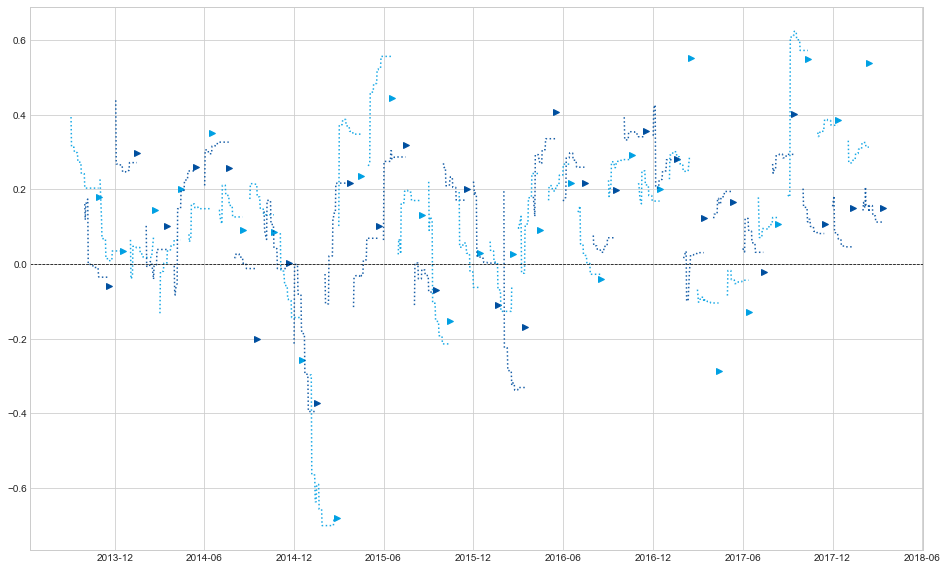

In [5]:
pred = df[["target_month", "date", "cpi"]].dropna()
actual = df[["target_month", "date", "actual_cpi"]].dropna()

ax = fig = plt.figure(figsize=(16, 10))

for i, col in zip(pred.target_month.unique(),
                  itertools.cycle(["#00a0e3", "#004f9f"])):
    t_ = pred[pred["target_month"] == i]
    plt.plot(t_.date, t_.cpi, color=col, ls=":", lw=1.5, alpha=.9)
    
    t__ = actual[actual["target_month"] == i]
    plt.plot(t__.date, t__.actual_cpi,
        color=col,
        marker=">", ms=6,
        ls=" ")

plt.axhline(y=0, color="black", ls="--", lw=.75);

In [*Nowcasting U.S. Headline and Core Inflation*](https://www.clevelandfed.org/newsroom-and-events/publications/working-papers/2014-working-papers/wp-1403-nowcasting-us-headline-and-core-inflation.aspx), Knotek and Zaman (2014) explain how the daily nowcast is improved with the publication of new data. I decide to evaluate the nowcasts in the following six cases.

| Case | Date | Example: Nowcasting target month is January |
|------|------|---------------------------------------------|
| 1    | Day 1 of the target month | First day of January,<br> assume have CPI and PCE through November.|
| 2    | Day 8 of the target month | Have at least one weekly retail gasoline reading,<br> have CPI and PCE through November.|
| 3    | Day 15 of the target month | Have at least two weekly retail gasoline readings,<br> assume receive CPI for December,<br> have PCE through November.|
| 4    | Day 22 of the target month | Have at least three weekly retail gasoline readings,<br> CPI through December,<br> PCE through November.
| 5    | Last day of the target month | Have all weekly retail gasoline readings,<br> CPI through December, <br> assume receive PCE for December.
| 6    | Day 15 of the following month | Have all weekly retail gasoline readings,<br> assume receive CPI for January,<br> have PCE through December.

In [6]:
month = df.target_month.unique()
actual = df.actual_cpi.dropna()

c_1 = []
c_2 = []
c_3 = []
c_4 = []
c_5 = []
c_6 = []

for i in month:
    c_1.append(df[df.target_month == i].cpi.iloc[0,])
    c_2.append(df[df.target_month == i].cpi.iloc[6,])
    c_3.append(df[df.target_month == i].cpi.iloc[11,])
    c_4.append(df[df.target_month == i].cpi.iloc[16,])
    c_5.append(df[(df.target_month == i) & (df.date.dt.month == int(str(i)[-2:]))].cpi.iloc[-1,])
    c_6.append(df[df.target_month == i].cpi.dropna().iloc[-1])

In [7]:
df_w_cases = pd.DataFrame({
    "month": month,
    "actual": actual,
    "c_1": c_1,
    "c_2": c_2,
    "c_3": c_3,
    "c_4": c_4,
    "c_5": c_5,
    "c_6": c_6
}).reset_index(drop=True)

There is a lot of improvement going from Case 1 to Case 2 nowcasts (top left and top middle).

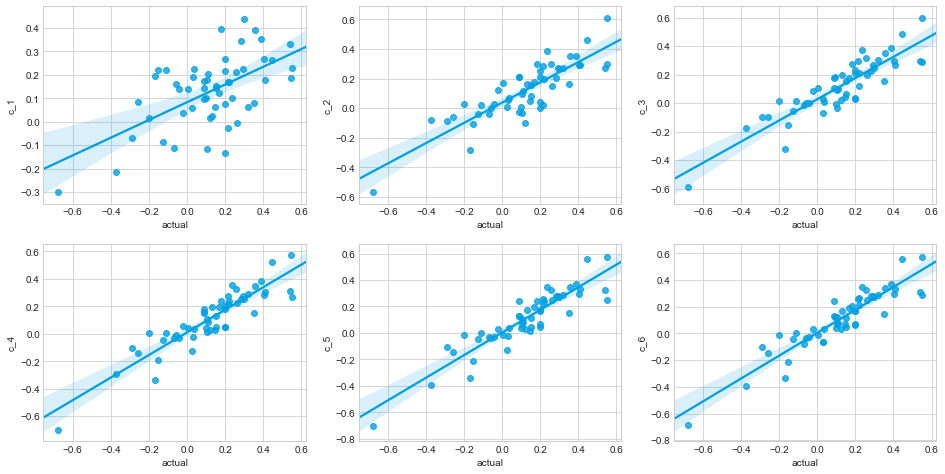

In [8]:
fig, axes = plt.subplots(2,3,figsize=(16,8))

for case in range(6):
    row = case // 3
    col = case % 3
    ax_curr = axes[row, col]
    sns.regplot(data=df_w_cases,
               x="actual",
               y="c_%s" %str(case+1),
               x_ci="sd",
               ax=ax_curr,
               color="#00a0e3")

From the adjusted R-squared, it can be confirmed that waiting for a week improves the predictive power of the nowcast a lot. 

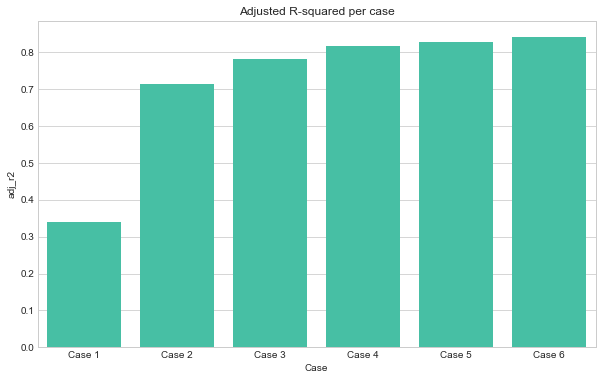

In [9]:
r2_list = []

for case in range(1, 7):
    model = sm.ols(formula="actual ~ c_%s" %case, data=df_w_cases)
    results = model.fit()
    r2_list.append(["Case %s" %case, results.rsquared_adj])

r2_df = pd.DataFrame(r2_list).rename(index=str, columns={0: "Case", 1: "adj_r2"})

plt.figure(figsize=(10, 6))
sns.barplot(x="Case", y="adj_r2", data=r2_df, color="#33d3af")
plt.title("Adjusted R-squared per case");

More details on the regressions.

In [10]:
for case in range(1, 7):
    model = sm.ols(formula="actual ~ c_%s" %case, data=df_w_cases)
    results = model.fit()
    print("=== Case %s ===" %case)
    print(results.summary())
    print("\n")

=== Case 1 ===
                            OLS Regression Results                            
Dep. Variable:                 actual   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     28.29
Date:                Wed, 21 Mar 2018   Prob (F-statistic):           2.24e-06
Time:                        18:33:51   Log-Likelihood:                 13.543
No. Observations:                  54   AIC:                            -23.09
Df Residuals:                      52   BIC:                            -19.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0020      0.035     